# Randomised benchmarking
This notebook loosely follows through the examples in the [corresponding Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/5a_randomized_benchmarking.ipynb).

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_london


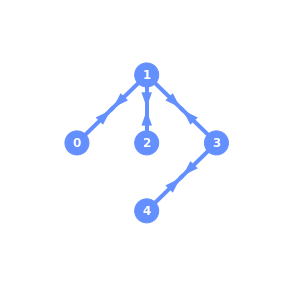

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration.
print(backend)
plot_gate_map(backend, plot_directed=True)

## Standard RB

In [4]:
import qiskit.ignis.verification.randomized_benchmarking as rb

# Parameters for the RB run:
nqs = 1                              # no. of qubits.
nseeds = 5                           # no. of random sequences.
ncliffs = np.arange(1, 500, 50)      # no. of Cliffords per sequence.
rb_pattern = [[0]]                   # Which sets of qubits you want to benchmark.
length_multiplier = [1]              # Scaling for each RB sequence.

In [5]:
rb_opts = {}
rb_opts['length_vector'] = ncliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier

# Generate RB circuits.
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)
rb_circs[0][0].draw()

┌───┐┌─────┐┌───┐┌───┐ ░ ┌───┐┌───┐┌───┐┌───┐┌─┐
qr_0: |0>┤ H ├┤ Sdg ├┤ H ├┤ Y ├─░─┤ Y ├┤ H ├┤ S ├┤ H ├┤M├
         └───┘└─────┘└───┘└───┘ ░ └───┘└───┘└───┘└───┘└╥┘
 cr_0: 0 ══════════════════════════════════════════════╩═

In [ ]:
# Running RB circuits.
result = []
for circ in rb_circs:
    job = execute(circ, backend, optimization_level=0, shots=1000)
    result.append(job.result())
    print(job.job_id())

5e48d811955bf1001899968a
5e48d8407e75340018ea3451
5e48d86a7e75340018ea3454
5e48d8957e75340018ea3458


In [ ]:
# Calculate exponential fit.
rb_fit = rb.fitters.RBFitter(result, xdata, rb_opts['rb_pattern'])
rb_fit.plot_rb_data()

## Interleaved RB

In [ ]:
# Same parameters as before, with an addition
interleaved_gates = [['h 0']]
rb_opts['interleaved_gates'] = interleaved_gates

In [ ]:
# Generate interleaved RB circuits.
rb_circs, xdata, irb_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [ ]:
# Running original RB circuits.
result = []
for rb_circ in rb_circs:
    job = execute(rb_circ, backend, optimization_level=0, shots=1000)
    result.append(job.result())
    print(job.job_id())

In [12]:
# Running interleaved RB circuits.
iresult = []
for irb_circ in irb_circs:
    job = execute(irb_circ, backend, optimization_level=0, shots=1000)
    iresult.append(job.result())
    print(job.job_id())

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
# Calculate exponential fit.
rb_fit = rb.RBFitter(result, xdata, rb_opts['rb_pattern'])
irb_fit = rb.RBFitter(iresult, xdata, rb_opts['rb_pattern'])

joint_rb_fit = rb.InterleavedRBFitter(result, iresult, xdata, rb_opts['rb_pattern'])
joint_rb_fit.plot_rb_data()

NameError: name 'PassManager' is not defined